In [1]:
import pandas as pd
import datetime
import pickle
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score,cross_validate,train_test_split

In [2]:
def group_labels(y,ratio,seed=None):
    np.random.seed(seed=seed)
    length = len(y)
    grpwidth = max(deno_decimalToFraction(ratio),deno_decimalToFraction(1-ratio))
    reg_grps = int(length/grpwidth) 
    grp=np.empty(length,dtype=int)
    for i in range(reg_grps):
        b_idx = i * grpwidth
        f_idx = b_idx + grpwidth
        grp[b_idx:f_idx] = np.random.choice(grpwidth,grpwidth,replace=False)
    grp[f_idx:length] = np.random.choice(grpwidth,length-f_idx,replace=False)
    return grp

In [3]:
def split_labels(X,y,grp,binwidth,ratio):
    sel = np.isin(grp,np.arange(int(binwidth*ratio)))
    y_test = y[sel]
    X_test = X[sel]
    sel = np.isin(grp,np.arange(int(binwidth*ratio)),invert=True)
    y_train = y[sel]
    X_train = X[sel]        
    return X_train, X_test, y_train, y_test

In [4]:
def tt_split(X,y,train_ratio,seed=None,val=False):
    X, y = shufflesort(X,y,seed)
    if val:
        valid_ratio = 1-train_ratio
        binwidth = max(deno_decimalToFraction(1-valid_ratio),deno_decimalToFraction(valid_ratio))
        ygrp = group_labels(y,valid_ratio,seed=seed)
        X_train, X_valid, y_train, y_valid = split_labels(X,y,ygrp,binwidth,valid_ratio)

        val_ratio = 0.5
        binwidth = max(deno_decimalToFraction(1-val_ratio),deno_decimalToFraction(val_ratio))
        ygrp = group_labels(y_valid,val_ratio,seed=seed)
        X_val, X_test, y_val, y_test = split_labels(X_valid,y_valid,ygrp,binwidth,val_ratio)

        return X_train, X_val, X_test, y_train, y_val, y_test 
    else:
        test_ratio = 1-train_ratio
        binwidth = max(deno_decimalToFraction(1-test_ratio),deno_decimalToFraction(test_ratio))
        ygrp = group_labels(y,test_ratio,seed=seed)
        X_train, X_test, y_train, y_test = split_labels(X,y,ygrp,binwidth,test_ratio)

        return X_train, X_test, y_train, y_test

In [5]:
from math import floor 
  
# Recursive function to 
# return GCD of a and b 
def gcd(a, b): 
      
    if (a == 0): 
        return b 
    elif (b == 0): 
        return a 
    if (a < b): 
        return gcd(a, b % a) 
    else: 
        return gcd(b, a % b) 

def deno_decimalToFraction(number):
# Returns denominator of fraction converted from decimal   
      
    # Fetch integral value of the decimal 
    intVal = floor(number) 
  
    # Fetch fractional part of the decimal 
    fVal = number - intVal 
  
    # Consider precision value to 
    # convert fractional part to 
    # integral equivalent 
    pVal = 1000000000
  
    # Calculate GCD of integral 
    # equivalent of fractional 
    # part and precision value 
    gcdVal = gcd(round(fVal * pVal), pVal) 
  
    # Calculate num and deno 
    num= round(fVal * pVal) // gcdVal 
    deno = pVal // gcdVal 

#     # Print the fraction 
#     print((intVal * deno) + num, "/", deno) 
  
    return deno 
  

In [6]:
def shufflesort(X,y,seed=None):
# Sorts dataset by label and shuffles labels with the same value
    np.random.seed(seed=seed)
    y_sorted = y.reset_index(drop=True).sort_values()
    idx = y_sorted.index.to_numpy()
    vc = y_sorted.value_counts()
    vals = list(vc[vc > 1].index)
    for val in vals:
        b_idx = y_sorted.index.get_loc(y_sorted[y_sorted==val].index[0])   # First index of value
        f_idx = y_sorted.index.get_loc(y_sorted[y_sorted==val].index[-1])  # Last index of value
        idx[b_idx:f_idx+1] = np.random.permutation(idx[b_idx:f_idx+1])     # Permute order of indices for value
    y_sorted = y_sorted.reindex(idx)
    y = y.iloc[y_sorted.index]
    X = X.iloc[y_sorted.index]
    return X,y

In [7]:
def ou_accuracy(actu,pred,masked=False):
    with open('data/df_2000_2019.pkl','rb') as f:
        dfall = pickle.load(f)
    ou = dfall.loc[actu.index,'Over_Under']
        
    if not((len(actu) == len(pred)) & (len(pred) == len(ou))):
        if (len(actu) != len(pred)):
            raise ValueError(f'Length mismatch among arguments: actual != predicted ({len(actu)} != {len(pred)})')
        else:
            raise ValueError(f'Length mismatch among arguments: predicted != Over/Under ({len(pred)} != {len(ou)})')
    else:
        if not(masked):
            corr = (((actu<ou) & (pred<ou)).sum() + ((actu>ou) & (pred>ou)).sum())
            tot = (actu<ou).sum() + (actu>ou).sum()
            return corr/tot
        else:
            mask = abs(pred-ou) >= 4
            actu = actu[mask]
            pred = pred[mask]
            ou = ou[mask]
            corr1 = (((actu<ou) & (pred<ou)).sum() + ((actu>ou) & (pred>ou)).sum())
            tot1 = (actu<ou).sum() + (actu>ou).sum()
            return corr1/tot1

In [8]:
def regress(reg,Xtrain,Xtest,ytrain,ytest,cv=5,print_metrics=True,print_coef=True,return_metrics=False):
    robust = RobustScaler()
    sca_train = robust.fit_transform(Xtrain)
    sca_test = robust.transform(Xtest)
    val = cross_validate(reg, sca_train, ytrain, cv=cv, return_estimator=True,
                                scoring={'mae':make_scorer(mean_absolute_error,greater_is_better=False),
                                        'acc':make_scorer(ou_accuracy,greater_is_better=True)})
    acc = (np.mean(val['test_acc']),np.std(val['test_acc']))
    mae = (np.mean(-val['test_mae']),np.std(-val['test_mae']))
    best_estimator = val['estimator'][val['test_mae'].argmax()]

    ypred=best_estimator.predict(sca_test)
    mae_test=mean_absolute_error(ytest,ypred)
    acc_test = ou_accuracy(ytest,ypred)
    sorted_coef = get_coef(best_estimator.coef_,Xtrain.columns)
    if print_metrics:
        print(f'MAE_train = {mae[0]:.3f}±{mae[1]:.3f}, Accuracy = {acc[0]:.3f}±{acc[1]:.3f}')
        print(-val['test_mae'])
#        print(f'MAE_test = {mae_test:.3f}, Accuracy_test = {acc_test:.3f}')
    if print_coef:
        print(sorted_coef)
    if return_metrics:
        return mae_test,acc_test
    else:
        return

In [9]:
def get_coef(coef_,cols):
    coef = pd.DataFrame(coef_, cols, columns=['LR Coefficient'])
    ind=np.flip(np.argsort(abs(coef_)))
    return coef.iloc[ind]

In [10]:
def cv_model(X,y,gfold,grp,model,scale=True):
    from sklearn.preprocessing import RobustScaler
    mae=[]
    acc=[]
    robust = RobustScaler()
#    for fold, (train_index, valid_index) in enumerate(gfold.split(X, y, grp)):
    for train_index, valid_index in gfold.split(X, y, grp):
        X_train,X_valid = X.iloc[train_index],X.iloc[valid_index]
        y_train,y_valid = y.iloc[train_index],y.iloc[valid_index]
        if scale:
            sca_train = robust.fit_transform(X_train)
            sca_valid = robust.transform(X_valid)
            model.fit(sca_train,y_train)
            y_pred = model.predict(sca_valid)
        else:
            model.fit(X_train,y_train)
            y_pred = model.predict(X_valid)            
        mae.append(mean_absolute_error(y_valid,y_pred))
        acc.append(ou_accuracy(y_valid,y_pred))
    print(model,f'n_splits = {gfold.get_n_splits()}')
    return mae, acc

In [11]:
def print_time():
    ct = datetime.datetime.now()
    print(ct.strftime('%m-%d-%y %H:%M:%S'))
    return

In [12]:
def plot_coef(OLS,p_thresh=None):
    if p_thresh is not None:
        mask = OLS.pvalues[1:] < p_thresh
        params = OLS.params[1:][mask]
        conf_int = OLS.conf_int()[1:][mask]
    else:
        params = OLS.params[1:]
        conf_int = OLS.conf_int()[1:]
        
    err_series = params - conf_int[0]
    coef_df = pd.DataFrame({'coef': params.values,
                            'err': err_series.values,
                            'varname': err_series.index.values
                           })
    fig, ax = plt.subplots(figsize=(8, 5))
    coef_df.plot(x='varname', y='coef', kind='bar', 
                 ax=ax, color='none', 
                 yerr='err', legend=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.scatter(x=np.arange(coef_df.shape[0]), 
               marker='s', s=120, 
               y=coef_df['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
    ax.xaxis.set_ticks_position('none')
    return

In [13]:
turf=['a_turf','astroplay','fieldturf','sportturf','matrixturf']
LR = linear_model.LinearRegression()
robust = RobustScaler()

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

path = 'data/df_2010_2019_5wk.pkl'
with open(path,'rb') as f:
    dfgame = pickle.load(f)

In [15]:
print_time()
train_ratio = 0.70
seed = 37
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
y = dfgame['Tot_Pts']

vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays']
X = X.drop(vifdrop,axis=1)
# W/out Pass/Rush Metrics, Scores, Possession, Plays, dome, TOs, TDs
X_train, X_val, X_test, y_train, y_val, y_test  = tt_split(X, y, train_ratio, seed=seed, val=True)

vif = pd.DataFrame()
vif['Features'] = X_train.columns
xarray = sm.add_constant(X_train.values)
vif['VIF Factor'] = [variance_inflation_factor(xarray,i) for i in range(1,len(X_train.columns)+1)]
vif.round(2).sort_values(by='VIF Factor',ascending=False)

02-01-21 20:13:14


,Features,VIF Factor
1,H_Pts_Opp,4.33
3,V_Pts_Opp,4.27
2,V_Pts,4.11
0,H_Pts,3.79
5,V_Off_Pass,2.99
4,H_Off_Pass,2.96
35,dome,2.44
7,V_Off_Rush,2.12
9,V_Def_Pass,2.11
6,H_Off_Rush,2.05


In [162]:
# Not scaled, no turf, High VIF Features dropped
import statsmodels.api as sm
train_ratio = 0.7
seed = 37
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
y = dfgame['Tot_Pts']

vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays']
X = X.drop(vifdrop,axis=1)
X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, seed=seed, val=True)
X_train = sm.add_constant(X_train)
X_val = sm.add_constant(X_val)
n_scaled = sm.OLS(y_train, X_train).fit()
ypred=n_scaled.predict(X_val)
print(f'MAE = {mean_absolute_error(y_val,ypred)}')
print(f'Validation Accuracy = {ou_accuracy(y_val,ypred)}')
#get_coef(LR.coef_,X_train.columns)
#plot_coef(n_scaled,p_thresh=0.10)
n_scaled.summary()

MAE = 11.115043909468985
Validation Accuracy = 0.5019607843137255


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Tot_Pts   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     4.407
Date:                Wed, 03 Feb 2021   Prob (F-statistic):           9.89e-17
Time:                        11:27:14   Log-Likelihood:                -4851.5
No. Observations:                1215   AIC:                             9781.
Df Residuals:                    1176   BIC:                             9980.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            348.3914    355.429      0.980      0.327    -348.954    1045.736
H_Pts              0.3109      0.140      2.228      0.026       0.037       0.585
H_Pts_Opp          0.1687      0.156      1.082      0.279      -0.137       0.474
V_Pts              0.0203      0.136      0.149      0.882      -0.248       0.288
V_Pts_Opp         -0.2242      0.153     -1.467      0.143      -0.524       0.076
H_Off_Pass         0.0181      0.015      1.197      0.231      -0.012       0.048
V_Off_Pass         0.0483      0.015      3.184      0.001       0.019       0.078
H_Off_Rush         0.0016      0.020      0.080      0.936      -0.037       0.040
V_Off_Rush         0.0351      0.020      1.734      0.083      -0.005       0.075
H_Def_Pass         0.0017      0.015      0.112      0.911      -0.028       0.031
V_Def_Pass         0.0421      0.015      2.802      0.005       0.013       0.072
H_Def_Rush         0.0392      0.020      1.928      0.054      -0.001       0.079
V_Def_Rush         0.0417      0.020      2.092      0.037       0.003       0.081
H_TD_on_Def       -4.9847      2.485     -2.006      0.045      -9.859      -0.110
V_TD_on_Def       -3.3616      2.506     -1.341      0.180      -8.278       1.555
H_FG_Pct          -3.8323      3.263     -1.175      0.240     -10.233       2.569
V_FG_Pct           3.1010      3.089      1.004      0.316      -2.960       9.162
H_RZ_Def_Pct      -3.7772      4.108     -0.919      0.358     -11.837       4.283
V_RZ_Def_Pct      16.2625      4.081      3.985      0.000       8.255      24.270
H_TO_Gain          0.8590      0.831      1.033      0.302      -0.772       2.490
V_TO_Gain          1.0641      0.829      1.283      0.200      -0.563       2.692
H_TO_Lost         -1.0125      0.859     -1.179      0.239      -2.698       0.673
V_TO_Lost          1.2698      0.829      1.531      0.126      -0.357       2.897
H_Yds_Pen          0.0130      0.031      0.413      0.680      -0.049       0.075
V_Yds_Pen          0.0210      0.032      0.666      0.505      -0.041       0.083
H_Sacks_Def        0.5003      0.628      0.796      0.426      -0.733       1.733
V_Sacks_Def        0.4326      0.633      0.683      0.495      -0.810       1.675
H_Tackles_Loss     0.4338      0.440      0.985      0.325      -0.430       1.298
V_Tackles_Loss     0.3032      0.427      0.711      0.477      -0.534       1.140
H_Kickret         -0.0656      0.076     -0.864      0.388      -0.215       0.083
V_Kickret         -0.0028      0.071     -0.039      0.969      -0.142       0.136
H_Puntret          0.0943      0.101      0.930      0.352      -0.105       0.293
V_Puntret         -0.2426      0.102     -2.378      0.018      -0.443      -0.042
Temperature       -0.0065      0.027     -0.241      0.810      -0.060       0.047
Wind        

MAE = 11.115043909468998
Validation Accuracy = 0.5019607843137255


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Tot_Pts   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     4.407
Date:                Tue, 02 Feb 2021   Prob (F-statistic):           9.89e-17
Time:                        15:53:45   Log-Likelihood:                -4851.5
No. Observations:                1215   AIC:                             9781.
Df Residuals:                    1176   BIC:                             9980.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             43.5351      0.638     68.205      0.000      42.283      44.787
H_Pts              2.1140      0.949      2.228      0.026       0.252       3.976
H_Pts_Opp          1.1469      1.060      1.082      0.279      -0.932       3.226
V_Pts              0.1541      1.037      0.149      0.882      -1.881       2.189
V_Pts_Opp         -1.6594      1.131     -1.467      0.143      -3.878       0.559
H_Off_Pass         1.0601      0.885      1.197      0.231      -0.677       2.797
V_Off_Pass         2.9236      0.918      3.184      0.001       1.122       4.725
H_Off_Rush         0.0569      0.712      0.080      0.936      -1.339       1.453
V_Off_Rush         1.2765      0.736      1.734      0.083      -0.168       2.721
H_Def_Pass         0.0857      0.763      0.112      0.911      -1.411       1.582
V_Def_Pass         2.1727      0.776      2.802      0.005       0.651       3.694
H_Def_Rush         1.2806      0.664      1.928      0.054      -0.023       2.584
V_Def_Rush         1.4768      0.706      2.092      0.037       0.092       2.862
H_TD_on_Def       -0.9969      0.497     -2.006      0.045      -1.972      -0.022
V_TD_on_Def       -0.6723      0.501     -1.341      0.180      -1.656       0.311
H_FG_Pct          -0.6387      0.544     -1.175      0.240      -1.706       0.428
V_FG_Pct           0.5367      0.535      1.004      0.316      -0.512       1.586
H_RZ_Def_Pct      -0.6480      0.705     -0.919      0.358      -2.031       0.735
V_RZ_Def_Pct       2.5678      0.644      3.985      0.000       1.303       3.832
H_TO_Gain          0.6872      0.665      1.033      0.302      -0.617       1.992
V_TO_Gain          0.8513      0.664      1.283      0.200      -0.451       2.153
H_TO_Lost         -0.8100      0.687     -1.179      0.239      -2.158       0.538
V_TO_Lost          1.0159      0.663      1.531      0.126      -0.286       2.318
H_Yds_Pen          0.2453      0.595      0.413      0.680      -0.921       1.412
V_Yds_Pen          0.3653      0.548      0.666      0.505      -0.710       1.441
H_Sacks_Def        0.6003      0.754      0.796      0.426      -0.879       2.080
V_Sacks_Def        0.5191      0.760      0.683      0.495      -0.972       2.010
H_Tackles_Loss     0.6508      0.660      0.985      0.325      -0.645       1.947
V_Tackles_Loss     0.5458      0.768      0.711      0.477      -0.960       2.052
H_Kickret         -0.4397      0.509     -0.864      0.388      -1.439       0.559
V_Kickret         -0.0187      0.475     -0.039      0.969      -0.952       0.914
H_Puntret          0.4299      0.462      0.930      0.352      -0.477       1.337
V_Puntret         -1.1563      0.486     -2.378      0.018      -2.110      -0.202
Temperature       -0.1762      0.732     -0.241      0.810      -1.611       1.259
Wind        

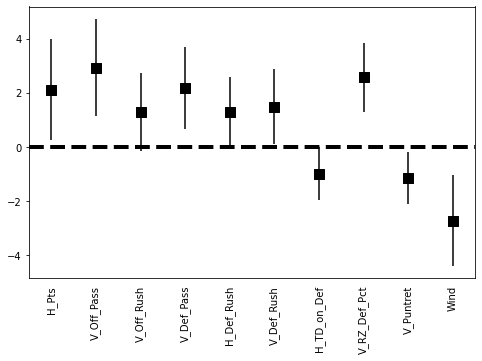

In [66]:
# Scaled, no turf, High VIF Features dropped
import statsmodels.api as sm
train_ratio = 0.7
seed = 37
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
y = dfgame['Tot_Pts']

vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays']
X = X.drop(vifdrop,axis=1)
X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, seed=seed, val=True)
sca_train = X_train
sca_train[sca_train.columns] = robust.fit_transform(sca_train[sca_train.columns])
sca_train = sm.add_constant(sca_train)
sca_val = robust.transform(X_val)
sca_val = sm.add_constant(sca_val)
scaled = sm.OLS(y_train, sca_train).fit()
ypred=scaled.predict(sca_val)
print(f'MAE = {mean_absolute_error(y_val,ypred)}')
print(f'Validation Accuracy = {ou_accuracy(y_val,ypred)}')
plot_coef(scaled,p_thresh=0.10)
scaled.summary()

In [136]:
thresh = 0.10
df1=n_scaled.summary2().tables[1]
df2=scaled.summary2().tables[1]
df=pd.concat([df1.iloc[:,0],df2.iloc[:,0],df1.iloc[:,3],df1.iloc[:,4],df1.iloc[:,5]],axis=1)
df.columns=['Unscaled','Scaled','p-coef','min','max']
threshed=df[df['p-coef']<thresh]

In [138]:
threshed.sort_values(by=['Scaled'],key=lambda x: abs(threshed['Scaled']),ascending=False).to_excel('ols_coef.xlsx')

In [139]:
threshed.sort_values(by=['Scaled'],key=lambda x: abs(threshed['Scaled']),ascending=False)

,Unscaled,Scaled,p-coef,min,max
V_Off_Pass,0.048324,2.923587,0.001490,0.018548,0.078100
Wind,-0.271791,-2.717907,0.001494,-0.439308,-0.104274
V_RZ_Def_Pct,16.262454,2.567756,0.000072,8.254773,24.270135
V_Def_Pass,0.042107,2.172711,0.005169,0.012618,0.071595
H_Pts,0.310877,2.113964,0.026085,0.037089,0.584665
V_Def_Rush,0.041718,1.476830,0.036650,0.002593,0.080844
H_Def_Rush,0.039162,1.280588,0.054130,-0.000696,0.079019
V_Off_Rush,0.035069,1.276494,0.083264,-0.004622,0.074759
V_Puntret,-0.242582,-1.156307,0.017557,-0.442709,-0.042455
H_TD_on_Def,-4.984654,-0.996931,0.045059,-9.859347,-0.109961


In [164]:
dfgame[dfgame['V_Game']>dfgame['H_Game']]['Tot_Pts'].mean()

44.74300932090546

In [165]:
dfgame[dfgame['V_Game']<dfgame['H_Game']]['Tot_Pts'].mean()

45.47959183673469

In [180]:
dfgame['V_Off_Pass'].corr(dfgame['Tot_Pts'])

0.16739107162855826

In [181]:
dfgame['H_Off_Pass'].corr(dfgame['Tot_Pts'])

0.13072478364675974

In [184]:
dfgame['V_Off_Pass'].corr(dfgame['V_Game'].astype('int'))

0.19870764352332926

In [185]:
dfgame['H_Off_Pass'].corr(dfgame['H_Game'].astype('int'))

0.1706253356325197

In [198]:
dfgame['H_Def_Rush'].corr(dfgame['V_Game'].astype('int'))

0.09800926897237958

In [199]:
dfgame['V_Def_Rush'].corr(dfgame['H_Game'].astype('int'))

0.1038621031484295

In [192]:
dfgame['Wind'].corr(dfgame['H_Game'].astype('int'))

-0.08233918068220109

In [193]:
dfgame['Wind'].corr(dfgame['V_Game'].astype('int'))

-0.06285708318520514

In [194]:
dfgame['Temperature'].corr(dfgame['H_Game'].astype('int'))

-0.008867109994968215

In [195]:
dfgame['Temperature'].corr(dfgame['V_Game'].astype('int'))

0.05716498816339912

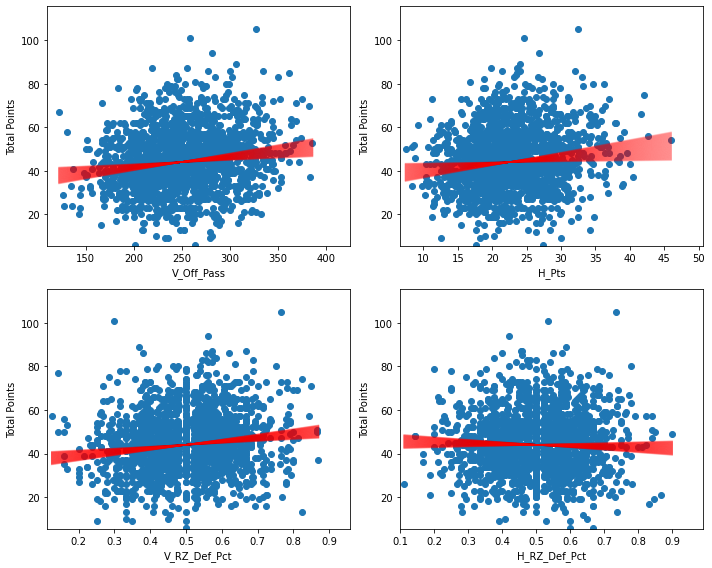

In [147]:
fig = plt.figure(figsize=(10,8))
cats = ['V_Off_Pass','H_Pts','V_RZ_Def_Pct','H_RZ_Def_Pct']
y = dfgame['Tot_Pts']
y0 = np.median(dfgame['Tot_Pts'])
for i,cat in enumerate(cats):
    i = i+1
    _ = fig.add_subplot(2,2,i)
    x = dfgame[cat]
#    m = df.loc[cat,'Unscaled']
    min_m = df.loc[cat,'min']
    max_m = df.loc[cat,'max']
    mm = np.linspace(min_m,max_m,100)
    x0 = np.median(dfgame[cat])
    plt.scatter(x,y)
    plt.xlabel(cat)
    plt.ylabel('Total Points')
    plt.xlim(min(x)*0.9,max(x)*1.1)
    plt.ylim(min(y)*0.9,max(y)*1.1)
    xx = np.linspace(min(x),max(x),500)
    b = y0-mm*x0
    for i in range(len(mm)):
        plt.plot(xx,mm[i]*xx+b[i],c='red',alpha=0.1)
plt.tight_layout()
plt.show()

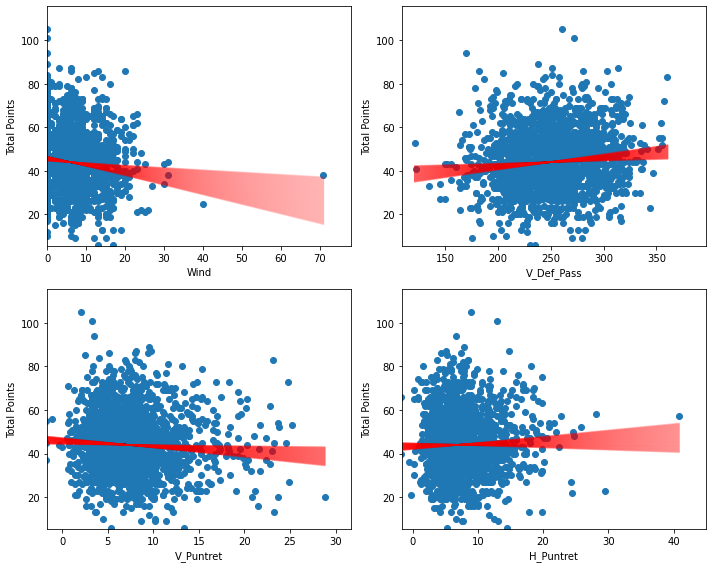

In [160]:
fig = plt.figure(figsize=(10,8))
cats = ['Wind','V_Def_Pass','V_Puntret','H_Puntret']
y = dfgame['Tot_Pts']
y0 = np.median(dfgame['Tot_Pts'])
for i,cat in enumerate(cats):
    i = i+1
    _ = fig.add_subplot(2,2,i)
    x = dfgame[cat]
#    m = df.loc[cat,'Unscaled']
    min_m = df.loc[cat,'min']
    max_m = df.loc[cat,'max']
    mm = np.linspace(min_m,max_m,100)
    x0 = np.median(dfgame[cat])
    plt.scatter(x,y)
    plt.xlabel(cat)
    plt.ylabel('Total Points')
    plt.xlim(min(x)*0.9,max(x)*1.1)
    plt.ylim(min(y)*0.9,max(y)*1.1)
    xx = np.linspace(min(x),max(x),500)
    b = y0-mm*x0
    for i in range(len(mm)):
        plt.plot(xx,mm[i]*xx+b[i],c='red',alpha=0.1)
plt.tight_layout()
plt.show()

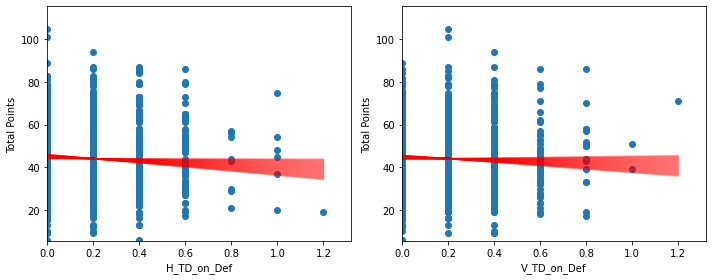

In [159]:
fig = plt.figure(figsize=(10,4))
cats = ['H_TD_on_Def','V_TD_on_Def']
y = dfgame['Tot_Pts']
y0 = np.median(dfgame['Tot_Pts'])
for i,cat in enumerate(cats):
    i = i+1
    _ = fig.add_subplot(1,2,i)
    x = dfgame[cat]
#    m = df.loc[cat,'Unscaled']
    min_m = df.loc[cat,'min']
    max_m = df.loc[cat,'max']
    mm = np.linspace(min_m,max_m,100)
    x0 = np.median(dfgame[cat])
    plt.scatter(x,y)
    plt.xlabel(cat)
    plt.ylabel('Total Points')
    plt.xlim(min(x)*0.9,max(x)*1.1)
    plt.ylim(min(y)*0.9,max(y)*1.1)
    xx = np.linspace(min(x),max(x),500)
    b = y0-mm*x0
    for i in range(len(mm)):
        plt.plot(xx,mm[i]*xx+b[i],c='red',alpha=0.1)
plt.tight_layout()
plt.show()

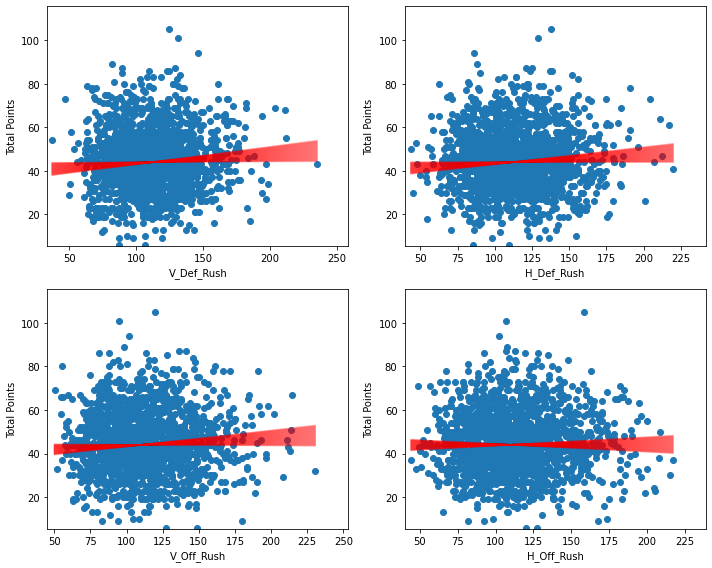

In [161]:
fig = plt.figure(figsize=(10,8))
cats = ['V_Def_Rush','H_Def_Rush','V_Off_Rush','H_Off_Rush']
y = dfgame['Tot_Pts']
y0 = np.median(dfgame['Tot_Pts'])
for i,cat in enumerate(cats):
    i = i+1
    _ = fig.add_subplot(2,2,i)
    x = dfgame[cat]
#    m = df.loc[cat,'Unscaled']
    min_m = df.loc[cat,'min']
    max_m = df.loc[cat,'max']
    mm = np.linspace(min_m,max_m,100)
    x0 = np.median(dfgame[cat])
    plt.scatter(x,y)
    plt.xlabel(cat)
    plt.ylabel('Total Points')
    plt.xlim(min(x)*0.9,max(x)*1.1)
    plt.ylim(min(y)*0.9,max(y)*1.1)
    xx = np.linspace(min(x),max(x),500)
    b = y0-mm*x0
    for i in range(len(mm)):
        plt.plot(xx,mm[i]*xx+b[i],c='red',alpha=0.1)
plt.tight_layout()
plt.show()

MAE = 11.038172158131122
Validation Accuracy = 0.515625


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Tot_Pts   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     3.969
Date:                Wed, 03 Feb 2021   Prob (F-statistic):           2.96e-14
Time:                        06:26:09   Log-Likelihood:                -4834.6
No. Observations:                1213   AIC:                             9747.
Df Residuals:                    1174   BIC:                             9946.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            473.4515    354.927      1.334      0.182    -222.911    1169.814
H_Pts              0.3573      0.137      2.614      0.009       0.089       0.625
H_Pts_Opp          0.1439      0.156      0.921      0.357      -0.163       0.451
V_Pts              0.0059      0.136      0.043      0.966      -0.260       0.272
V_Pts_Opp         -0.1899      0.151     -1.257      0.209      -0.486       0.107
H_Off_Pass         0.0075      0.015      0.498      0.618      -0.022       0.037
V_Off_Pass         0.0464      0.015      3.086      0.002       0.017       0.076
H_Off_Rush        -0.0047      0.020     -0.243      0.808      -0.043       0.034
V_Off_Rush         0.0358      0.020      1.784      0.075      -0.004       0.075
H_Def_Pass        -0.0029      0.015     -0.193      0.847      -0.033       0.027
V_Def_Pass         0.0331      0.015      2.218      0.027       0.004       0.062
H_Def_Rush         0.0311      0.020      1.538      0.124      -0.009       0.071
V_Def_Rush         0.0338      0.020      1.716      0.086      -0.005       0.072
H_TD_on_Def       -4.8157      2.480     -1.942      0.052      -9.681       0.050
V_TD_on_Def       -2.5735      2.493     -1.032      0.302      -7.465       2.318
H_FG_Pct          -2.1763      3.212     -0.678      0.498      -8.479       4.126
V_FG_Pct           3.7511      3.068      1.223      0.222      -2.268       9.771
H_RZ_Def_Pct      -2.6245      4.132     -0.635      0.525     -10.731       5.482
V_RZ_Def_Pct      15.9557      4.069      3.921      0.000       7.972      23.939
H_TO_Gain          0.6783      0.825      0.822      0.411      -0.941       2.298
V_TO_Gain          1.0000      0.826      1.210      0.226      -0.621       2.621
H_TO_Lost         -0.6300      0.854     -0.737      0.461      -2.306       1.046
V_TO_Lost          1.2012      0.820      1.465      0.143      -0.407       2.809
H_Yds_Pen          0.0323      0.031      1.034      0.301      -0.029       0.094
V_Yds_Pen          0.0342      0.031      1.091      0.276      -0.027       0.096
H_Sacks_Def        0.2261      0.623      0.363      0.717      -0.997       1.449
V_Sacks_Def        0.1043      0.626      0.167      0.868      -1.124       1.332
H_Tackles_Loss     0.2841      0.438      0.648      0.517      -0.576       1.144
V_Tackles_Loss     0.2560      0.421      0.608      0.543      -0.570       1.082
H_Kickret         -0.0972      0.076     -1.279      0.201      -0.246       0.052
V_Kickret         -0.0664      0.071     -0.937      0.349      -0.206       0.073
H_Puntret         -0.0530      0.101     -0.525      0.600      -0.251       0.145
V_Puntret         -0.1864      0.100     -1.869      0.062      -0.382       0.009
Temperature        0.0051      0.027      0.191      0.848      -0.047       0.057
Wind        

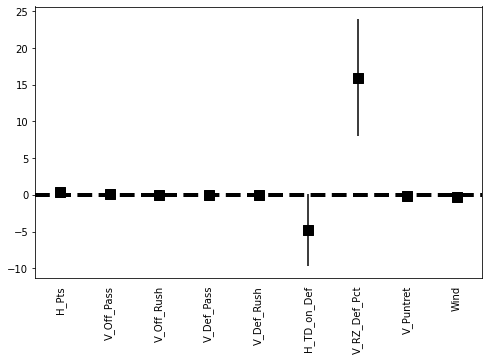

In [156]:
# Not scaled, no turf, High VIF Features dropped
import statsmodels.api as sm

dropped = ['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game','a_turf','astroplay','fieldturf',
           'sportturf','matrixturf','H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric',
           'V_Rush_Metric','H_RZ_Pct','V_RZ_Pct','H_Poss','V_Poss','H_Plays','V_Plays']
X = dfgame[dfgame['Wind']<35].drop(dropped,axis=1)
y = dfgame[dfgame['Wind']<35]['Tot_Pts']

train_ratio = 0.7
seed = 37
X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, seed=seed, val=True)
X_train = sm.add_constant(X_train)
X_val = sm.add_constant(X_val)
n_scaled = sm.OLS(y_train, X_train).fit()
ypred=n_scaled.predict(X_val)
print(f'MAE = {mean_absolute_error(y_val,ypred)}')
print(f'Validation Accuracy = {ou_accuracy(y_val,ypred)}')
#get_coef(LR.coef_,X_train.columns)
plot_coef(n_scaled,p_thresh=0.10)
n_scaled.summary()

In [24]:
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
corrs = pd.Series(index=X.columns)
for col in X.columns:
    corrs[col] = X['H_TO_Lost'].corr(X[col])
print(corrs.sort_values(ascending=False))

H_TO_Lost         1.000000
H_Pts_Opp         0.380030
H_Def_Rush        0.151336
H_Tackles_Loss    0.094615
V_Pass_Metric     0.080347
V_Kickret         0.070644
Temperature       0.066255
H_RZ_Def_Pct      0.062727
H_Kickret         0.059812
grass             0.056707
V_TO_Gain         0.049830
H_Plays           0.048128
V_Poss            0.042004
V_Plays           0.034739
V_RZ_Def_Pct      0.034583
V_Off_Rush        0.034256
H_Off_Pass        0.028625
V_Pts_Opp         0.028274
V_FG_Pct          0.019929
V_Def_Pass        0.019772
astroplay         0.018589
a_turf            0.017669
V_TO_Lost         0.015433
V_Pts             0.008351
V_Puntret         0.007619
V_Def_Rush        0.007101
H_Pass_Metric     0.005753
H_Puntret        -0.007091
V_TD             -0.007111
dome             -0.008404
V_Off_Pass       -0.011142
Wind             -0.013413
matrixturf       -0.013695
sportturf        -0.013925
V_TD_on_Def      -0.027196
V_Sacks_Def      -0.029037
V_Yds_Pen        -0.033762
V

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [269]:
print_time()
seed = 37
n_splits = 5
train_ratio = 0.85
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
X = X.drop(['a_turf','astroplay','dome','fieldturf','grass','matrixturf','sportturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
LR = linear_model.LinearRegression()
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
mae, acc = cv_model(X_train,y_train,GKF,groups,LR,scale=True)
print('MAE: {0:.3f}±{1:.3f}'.format(np.mean(mae), np.std(mae)))
print('acc: {0:.3f}±{1:.3f}'.format(np.mean(acc), np.std(acc)))

12-23-20 05:59:08
LinearRegression() n_splits = 5
MAE: 10.767±0.254
acc: 0.520±0.037


In [372]:
print_time()
seed = 37
n_splits = 5
train_ratio = 0.85
X = pd.concat([dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1),
              pd.get_dummies(dfgame[['Home_Team','Vis_Team']],prefix=['H','V'])],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
X = X.drop(['a_turf','astroplay','dome','fieldturf','grass','matrixturf','sportturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
RF=ensemble.RandomForestRegressor(random_state=seed,n_estimators=100,max_depth=8,max_features=8,
                                        criterion='mae')
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
mae, acc = cv_model(X_train,y_train,GKF,groups,RF,scale=False)
print('MAE: {0:.3f}±{1:.3f}'.format(np.mean(mae), np.std(mae)))
print('acc: {0:.3f}±{1:.3f}'.format(np.mean(acc), np.std(acc)))
importances = pd.Series(RF.feature_importances_,index=X_train.columns,name='Importances')
print(importances[0:60].sort_values(ascending=False))

12-23-20 09:42:45
RandomForestRegressor(criterion='mae', max_depth=8, max_features=8,
                      random_state=37) n_splits = 5
MAE: 10.688±0.063
acc: 0.530±0.015
V_Off_Pass                0.052543
V_Pts                     0.045974
V_Def_Pass                0.042647
V_RZ_Def_Pct              0.037533
H_Pts                     0.037109
H_Off_Rush                0.035412
V_Puntret                 0.034564
H_Off_Pass                0.034040
H_Def_Pass                0.031930
H_Puntret                 0.031561
H_RZ_Def_Pct              0.030387
V_Off_Rush                0.030282
H_Def_Rush                0.029602
H_Pts_Opp                 0.029478
Temperature               0.026922
H_Kickret                 0.026653
V_Kickret                 0.026308
V_Def_Rush                0.025960
V_FG_Pct                  0.023781
V_Tackles_Loss            0.023251
V_Yds_Pen                 0.023152
V_Pts_Opp                 0.022885
Wind                      0.022394
H_Tackles_Loss        

In [373]:
print_time()
seed = 37
n_splits = 5
train_ratio = 0.85
X = pd.concat([dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1),
              pd.get_dummies(dfgame[['Home_Team','Vis_Team']],prefix=['H','V'])],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
X = X.drop(['a_turf','astroplay','dome','fieldturf','grass','matrixturf','sportturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
RF=ensemble.RandomForestRegressor(random_state=seed,n_estimators=100,max_depth=8,
                                        criterion='mae')
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
mae, acc = cv_model(X_train,y_train,GKF,groups,RF,scale=False)
print('MAE: {0:.3f}±{1:.3f}'.format(np.mean(mae), np.std(mae)))
print('acc: {0:.3f}±{1:.3f}'.format(np.mean(acc), np.std(acc)))
importances = pd.Series(RF.feature_importances_,index=X_train.columns,name='Importances')
print(importances[0:60].sort_values(ascending=False))

12-23-20 09:44:16
RandomForestRegressor(criterion='mae', max_depth=8, random_state=37) n_splits = 5
MAE: 10.703±0.108
acc: 0.523±0.028
V_Off_Pass                0.065834
V_Def_Pass                0.052573
H_Off_Pass                0.043338
V_Pts                     0.041548
V_Puntret                 0.041120
H_Pts                     0.040080
H_Off_Rush                0.037102
Temperature               0.037060
V_Off_Rush                0.036036
H_Puntret                 0.035185
H_Pts_Opp                 0.031473
H_Def_Pass                0.029406
H_Kickret                 0.029169
V_RZ_Def_Pct              0.028571
V_Kickret                 0.028018
H_RZ_Def_Pct              0.027868
H_Yds_Pen                 0.027679
V_Def_Rush                0.027581
V_Yds_Pen                 0.027226
Wind                      0.026849
H_FG_Pct                  0.024934
H_Def_Rush                0.023231
V_Pts_Opp                 0.023096
V_Sacks_Def               0.020049
V_Tackles_Loss           

In [376]:
print_time()
seed = 37
train_ratio = 0.70
X = pd.concat([dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1),
              pd.get_dummies(dfgame[['Home_Team','Vis_Team']],prefix=['H','V'])],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','matrixturf','sportturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, seed=seed, val=True)
RF=ensemble.RandomForestRegressor(random_state=seed,n_estimators=100,max_depth=8, max_features=8,
                                        criterion='mae')
RF.fit(X_train, y_train)
ypred = RF.predict(X_val)
mae = mean_absolute_error(y_val, ypred) 
acc = ou_accuracy(y_val, ypred)
print('MAE: {0:.3f}'.format(mae))
print('acc: {0:.3f}'.format(acc))
importances = pd.Series(RF.feature_importances_,index=X_train.columns,name='Importances')
print(importances[0:60].sort_values(ascending=False))

12-23-20 10:02:10
MAE: 10.803
acc: 0.518
V_Off_Pass                0.061478
V_Def_Pass                0.039852
H_Off_Pass                0.039629
V_Puntret                 0.037195
H_Pts                     0.037179
V_RZ_Def_Pct              0.036089
H_Pts_Opp                 0.033668
V_Pts_Opp                 0.033090
V_Pts                     0.032966
H_Def_Pass                0.032807
Wind                      0.031999
H_Puntret                 0.030565
H_Off_Rush                0.029399
Temperature               0.028285
H_Def_Rush                0.028053
V_Kickret                 0.027586
V_Off_Rush                0.027398
V_Def_Rush                0.026224
V_Yds_Pen                 0.024733
H_RZ_Def_Pct              0.023829
H_Kickret                 0.023662
H_Yds_Pen                 0.022941
Week                      0.021434
V_FG_Pct                  0.019506
H_Sacks_Def               0.019315
V_Tackles_Loss            0.018633
H_Tackles_Loss            0.016869
H_FG_Pct      

In [291]:
print_time()
seed = 37
n_splits = 5
train_ratio = 0.85
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
X = X.drop(['a_turf','astroplay','dome','fieldturf','grass','matrixturf','sportturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
lasso = Lasso(alpha = 0.009, normalize=True)
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
mae, acc = cv_model(X_train,y_train,GKF,groups,lasso,scale=True)
print('MAE: {0:.3f}±{1:.3f}'.format(np.mean(mae), np.std(mae)))
print('acc: {0:.3f}±{1:.3f}'.format(np.mean(acc), np.std(acc)))

12-23-20 06:41:28
Lasso(alpha=0.009, normalize=True) n_splits = 5
MAE: 10.715±0.197
acc: 0.523±0.030


In [262]:
print_time()
seed = 37
n_splits = 5
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
X = X.drop(['a_turf','astroplay','dome','fieldturf','grass','matrixturf','sportturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
ridge = Ridge(alpha = 0.68, normalize=True)
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
mae, acc = cv_model(X_train,y_train,GKF,groups,ridge,scale=True)
print('MAE: {0:.3f}±{1:.3f}'.format(np.mean(mae), np.std(mae)))
print('acc: {0:.3f}±{1:.3f}'.format(np.mean(acc), np.std(acc)))

12-23-20 05:39:29
Ridge(alpha=0.68, normalize=True) n_splits = 5
MAE: 10.693±0.147
acc: 0.527±0.022


In [ ]:
# Random Forest
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
import graphviz
train_ratio = 0.85
param_grid = [{'n_estimators' : [200, 400, 800, 1000], 'max_depth' : [3, 6, 8, 10], 
              'max_features' : [4, 8, 16, 32, 'auto']}]
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=37)
RF = ensemble.RandomForestRegressor(random_state=77,criterion='mae')
grid_search = GridSearchCV(RF, param_grid, cv=5, 
                           scoring={'mae':make_scorer(mean_absolute_error,greater_is_better=False)},refit='mae')
grid_search.fit(X_train, y_train)

In [683]:
import graphviz
from sklearn.tree import export_graphviz
for i in range(10):
    ind = i*80
    dot_data = export_graphviz(grid_search.best_estimator_.estimators_[i], 
                               out_file=f'plots/RF_Trees/tree{i+1}.dot',
                               filled=True, rounded=True, feature_names=X.columns)

In [281]:
print_time()
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
train_ratio = 0.85
seed = 37
n_splits = 5
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf'],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
lasso = Lasso(normalize=True)
#alphas=np.logspace(-4, 0, 17)
alphas=np.logspace(-2.5, -2, 10)
param_grid = [{'alpha' : alphas}]
scoring={'mae':make_scorer(mean_absolute_error,greater_is_better=False),
         'acc':make_scorer(ou_accuracy,greater_is_better=True)}
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
print(lasso,f'n_splits = {GKF.get_n_splits()}')
GS = GridSearchCV(lasso, param_grid, cv=GKF.split(X_train,y_train,groups), scoring=scoring, refit='mae')
GS.fit(X_train, y_train)
GS.cv_results_

12-23-20 06:34:12
Lasso(normalize=True) n_splits = 5


{'mean_fit_time': array([0.01234055, 0.01287851, 0.01312771, 0.00820441, 0.00967746,
        0.0136869 , 0.01172776, 0.01011806, 0.00851989, 0.01162357]),
 'std_fit_time': array([0.00231181, 0.00128996, 0.00413259, 0.00114669, 0.00324002,
        0.00180229, 0.00277348, 0.00109844, 0.00126114, 0.00274582]),
 'mean_score_time': array([0.01749578, 0.0190661 , 0.0217063 , 0.01221418, 0.01590095,
        0.0185637 , 0.01650739, 0.01368437, 0.01187415, 0.01777945]),
 'std_score_time': array([0.00134866, 0.00289884, 0.01135463, 0.00028763, 0.00312797,
        0.00139106, 0.00310656, 0.00188267, 0.00023649, 0.00438768]),
 'param_alpha': masked_array(data=[0.0031622776601683794, 0.003593813663804626,
                    0.004084238652674522, 0.004641588833612777,
                    0.00527499706370262, 0.005994842503189409,
                    0.006812920690579615, 0.007742636826811269,
                    0.008799225435691074, 0.01],
              mask=[False, False, False, False, False, Fal

In [388]:
print_time()
from sklearn.linear_model import Lasso
train_ratio = 0.70
seed = 37
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','grass','sportturf','matrixturf','dome','fieldturf'],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
y = dfgame['Tot_Pts']
X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, val=True,seed=seed)
sca_train = robust.fit_transform(X_train)
sca_val = robust.transform(X_val)
#lasso = Lasso(alpha = 0.007, normalize=True)
lasso = Lasso(alpha = 0.011, normalize=True)
scoring={'mae':make_scorer(mean_absolute_error,greater_is_better=False),
         'acc':make_scorer(ou_accuracy,greater_is_better=True)}
lasso.fit(sca_train,y_train)
ypred=lasso.predict(sca_val)
mae=mean_absolute_error(y_val,ypred)
acc=ou_accuracy(y_val,ypred)
sorted_coef = get_coef(lasso.coef_,X_train.columns)
print(f'MAE = {mean_absolute_error(y_val,ypred)}')
print(f'Validation Accuracy = {ou_accuracy(y_val,ypred)}')
print(sorted_coef)
plot_coef()

12-23-20 10:14:08
MAE = 10.817601401649306
Validation Accuracy = 0.5215686274509804
                LR Coefficient
Wind                 -2.346999
V_Off_Pass            2.100770
H_Pts                 1.734814
V_RZ_Def_Pct          1.590835
H_Off_Pass            0.930776
V_Def_Pass            0.917549
V_Puntret            -0.567506
H_Def_Rush            0.531299
V_Pts                 0.428116
V_Off_Rush            0.257821
Week                 -0.206921
V_FG_Pct              0.094634
H_Sacks_Def           0.046750
H_Def_Pass            0.029045
H_Tackles_Loss        0.008790
V_Pts_Opp             0.000000
H_Off_Rush            0.000000
H_Pts_Opp             0.000000
Year                 -0.000000
V_Def_Rush            0.000000
H_FG_Pct             -0.000000
H_Yds_Pen             0.000000
V_Yds_Pen             0.000000
V_Sacks_Def           0.000000
V_Tackles_Loss        0.000000
H_Kickret            -0.000000
V_Kickret             0.000000
H_Puntret             0.000000
Temperature      

In [277]:
print_time()
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
train_ratio = 0.85
seed = 37
n_splits = 5
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct',
         'H_Poss','V_Poss','H_Plays','V_Plays','H_TO_Gain','V_TO_Gain','H_TO_Lost','V_TO_Lost','H_TD_on_Def',
         'V_TD_on_Def']
X = X.drop(vifdrop,axis=1)
X = X.drop(['a_turf','astroplay','dome','fieldturf','grass','matrixturf','sportturf'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed)
ridge = Ridge(normalize=True)
#alphas=np.logspace(-4, 0, 17)
alphas=np.logspace(-0.5, 0, 10)
param_grid = [{'alpha' : alphas}]
scoring={'mae':make_scorer(mean_absolute_error,greater_is_better=False),
         'acc':make_scorer(ou_accuracy,greater_is_better=True)}
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
print(ridge,f'n_splits = {GKF.get_n_splits()}')
GS = GridSearchCV(ridge, param_grid, cv=GKF.split(X_train,y_train,groups), scoring=scoring, refit='mae')
GS.fit(X_train, y_train)
GS.cv_results_

12-23-20 06:27:40
Ridge(normalize=True) n_splits = 5


{'mean_fit_time': array([0.00662355, 0.00620189, 0.00659041, 0.01019902, 0.00662813,
        0.00459962, 0.00493422, 0.00523987, 0.00508809, 0.00470967]),
 'std_fit_time': array([1.06873087e-03, 4.70826378e-04, 7.32216356e-04, 4.75401948e-03,
        2.31460558e-03, 8.30806341e-05, 5.55422771e-04, 7.04808850e-04,
        4.76338197e-04, 1.33575477e-04]),
 'mean_score_time': array([0.01678848, 0.01608653, 0.01694975, 0.02073178, 0.01406131,
        0.01187768, 0.01256819, 0.0118567 , 0.01250119, 0.01171784]),
 'std_score_time': array([0.00140863, 0.00159323, 0.00050524, 0.00208965, 0.00211319,
        0.00056319, 0.00184516, 0.00058217, 0.00059206, 0.00045904]),
 'param_alpha': masked_array(data=[0.31622776601683794, 0.35938136638046275,
                    0.4084238652674521, 0.46415888336127786,
                    0.5274997063702618, 0.599484250318941,
                    0.6812920690579612, 0.774263682681127,
                    0.8799225435691069, 1.0],
              mask=[False, F

In [14]:
train_ratio = 0.85
mae = np.empty(7)
acc = np.empty(7)
ou = np.empty(7)
acc_ext = np.empty(7)
for n in range(7):
    path = 'data/df_working'+str(n+1)+'.pkl'
    with open(path,'rb') as f:
        dfgame = pickle.load(f)
    yy = dfgame['Tot_Pts']
    XX = dfgame.drop(['Tot_Pts','Over/Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
    XX = XX.drop(turf,axis=1)
    XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size = 1-train_ratio, random_state=77)
    m, a = regress(LR,XX_train,XX_test,yy_train,yy_test,
                   print_metrics=False,print_coef=False,return_metrics=True)
    ou[n] = mean_absolute_error(yy_test,dfgame.loc[XX_test.index,'Over/Under'])
    mae[n] = m
    acc[n] = a
print(mae)
print(acc)
print(ou-mae)

[11.34933801 11.16744056 10.48705836 10.59635947 11.09379895 10.69871393
 10.22553897]
[0.45892351 0.53012048 0.50645161 0.51590106 0.54509804 0.55339806
 0.51442308]
[-0.83544912 -0.44422627 -0.28513529 -0.24095878 -0.50567634 -0.25767619
 -0.40714275]
